In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
import matplotlib.patches as patches
import pandas as pd
from tqdm import tqdm
import cv2
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage import feature
import pickle
from sklearn.preprocessing import StandardScaler
import random
import pickle

In [3]:
from cars_detector.utils  import read_test_frame, read_frame
from cars_detector.sampling import sampling
from cars_detector.augmentation import random_augmentation
from cars_detector.features import compute_features, compute_colors_features
from cars_detector.makebox import non_max_suppression, box_otsu
from cars_detector.splitpictures import pyramid

In [2]:
df_ground_truth = pd.read_csv('train.csv')

In [7]:
img = read_frame(df_ground_truth,1)

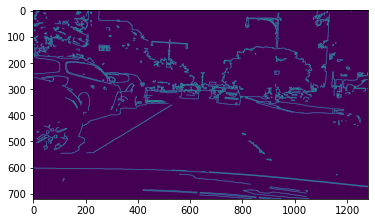

In [21]:
edges = cv2.Canny(img,500,200)
plt.imshow(edges)


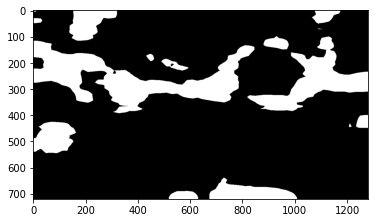

In [41]:
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
(success, saliencyMap) = saliency.computeSaliency(img)
saliencyMap = (saliencyMap * 255).astype("uint8")
threshMap = cv2.threshold(saliencyMap.astype("uint8"), 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(threshMap, cmap = 'gray')

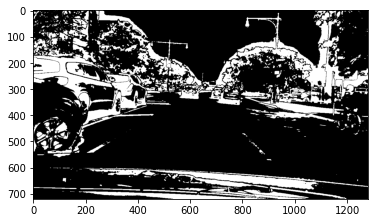

In [44]:
saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliencyMap) = saliency.computeSaliency(img)
# if we would like a *binary* map that we could process for contours,
# compute convex hull's, extract bounding boxes, etc., we can
# additionally threshold the saliency map
saliencyMap = (saliencyMap * 255).astype("uint8")
threshMap = cv2.threshold(saliencyMap.astype("uint8"), 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(threshMap, cmap = "gray")

In [46]:
saliency = cv2.saliency.ObjectnessBING_create()
# compute the bounding box predictions used to indicate saliency
(success, saliencyMap) = saliency.computeSaliency(img)


Can't load model: /ObjNessB2W8MAXBGR.wS1 or /ObjNessB2W8MAXBGR.idx
Can't load model: /ObjNessB2W8HSV.wS1 or /ObjNessB2W8HSV.idx
Can't load model: /ObjNessB2W8I.wS1 or /ObjNessB2W8I.idx


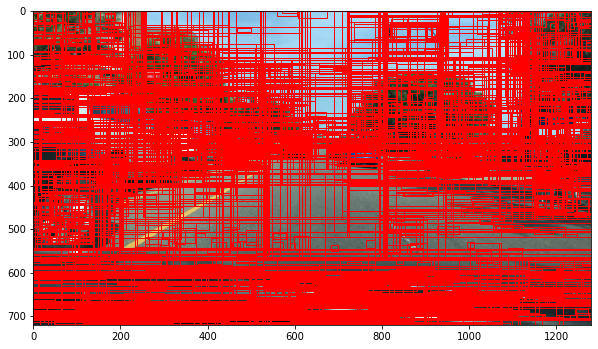

In [48]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
#ss.switchToSelectiveSearchQualit
rects = ss.process()
fig, ax = plt.subplots(figsize=(10, 8))

for x, y, dx, dy in rects:

    rect = patches.Rectangle((x, y), dx, dy, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(img)


In [49]:
print(len(rects))

5118


In [50]:
cv2.BackgroundSubtractorMOG(img)

AttributeError: module 'cv2' has no attribute 'BackgroundSubtractorMOG'

In [54]:
res = cv2.BackgroundSubtractorMOG2(img)
res

<BackgroundSubtractorMOG2 0x7ff5b80c29d0>

In [44]:
old_frame = read_frame(df_ground_truth,1)
frame = read_frame(df_ground_truth,2)
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None,maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

mask = np.zeros_like(old_gray)


In [45]:
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None)
good_new = p1[st == 1]
good_old = p0[st == 1]

In [46]:
mask = np.zeros_like(old_frame)

for i, (new, old) in enumerate(zip(good_new, good_old)):

    a, b = new.astype('int32').ravel()
    c, d = old.astype('int32').ravel()
    mask = cv2.line(mask, (a, b), (c, d),  2)
    frame = cv2.circle(frame, (a, b), 5,-1)

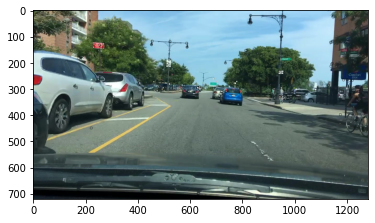

In [47]:
plt.imshow(frame)